In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [4]:
original_data_dir = r"D:\MED_LEAF_ID-1\data\cnn\original"
augmented_data_dir =  r"D:\MED_LEAF_ID-1\data\cnn\augmented"


In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

In [6]:
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_data = datasets.ImageFolder(root=original_data_dir, transform=train_transforms)
augmented_data = datasets.ImageFolder(root=augmented_data_dir, transform=train_transforms)


full_train_data = torch.utils.data.ConcatDataset([train_data, augmented_data])


train_size = int(0.7 * len(full_train_data))
val_size = int(0.15 * len(full_train_data))
test_size = len(full_train_data) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_train_data, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
class EfficientNetB0Classifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB0Classifier, self).__init__()
        self.base_model = torchvision.models.efficientnet_b0(pretrained=True)
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, num_classes)
        self.base_model.classifier.add_module('dropout', nn.Dropout(0.2))  
    def forward(self, x):
        return self.base_model(x)

In [9]:
num_classes = len(train_data.classes)
model = EfficientNetB0Classifier(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)
criterion = nn.CrossEntropyLoss()

y_train = [label for _, label in train_dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

d:\MED_LEAF_ID-1\base\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\MED_LEAF_ID-1\base\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs=30, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = model.state_dict()
    
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds.double() / total_preds

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels.data)
                total_preds += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct_preds.double() / total_preds

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
for inputs, labels in train_loader:
    print("Labels in batch:", labels[:10].cpu().numpy()) 
    break

Labels in batch: [ 4 32 58 50 69 52 39 13 48 55]


In [15]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, train_loader, val_loader, optimizer, criterion, num_epochs=50, patience=5
)


Training Epoch 1/50: 100%|██████████| 302/302 [04:34<00:00,  1.10it/s]


Epoch 1/50 => Train Loss: 0.9864, Train Accuracy: 0.7300, Val Loss: 0.4326, Val Accuracy: 0.8821


Training Epoch 2/50: 100%|██████████| 302/302 [04:13<00:00,  1.19it/s]


Epoch 2/50 => Train Loss: 0.9990, Train Accuracy: 0.7297, Val Loss: 0.5241, Val Accuracy: 0.8585


Training Epoch 3/50: 100%|██████████| 302/302 [05:17<00:00,  1.05s/it]


Epoch 3/50 => Train Loss: 0.9898, Train Accuracy: 0.7320, Val Loss: 0.4885, Val Accuracy: 0.8628


Training Epoch 4/50: 100%|██████████| 302/302 [04:37<00:00,  1.09it/s]


Epoch 4/50 => Train Loss: 0.9750, Train Accuracy: 0.7345, Val Loss: 0.4676, Val Accuracy: 0.8749


Training Epoch 5/50: 100%|██████████| 302/302 [04:21<00:00,  1.15it/s]


Epoch 5/50 => Train Loss: 0.9823, Train Accuracy: 0.7308, Val Loss: 0.4111, Val Accuracy: 0.8812


Training Epoch 6/50: 100%|██████████| 302/302 [04:22<00:00,  1.15it/s]


Epoch 6/50 => Train Loss: 0.9391, Train Accuracy: 0.7419, Val Loss: 0.4525, Val Accuracy: 0.8778


Training Epoch 7/50: 100%|██████████| 302/302 [04:24<00:00,  1.14it/s]


Epoch 7/50 => Train Loss: 0.9728, Train Accuracy: 0.7316, Val Loss: 0.4012, Val Accuracy: 0.8894


Training Epoch 8/50: 100%|██████████| 302/302 [04:07<00:00,  1.22it/s]


Epoch 8/50 => Train Loss: 0.9756, Train Accuracy: 0.7299, Val Loss: 0.4102, Val Accuracy: 0.8845


Training Epoch 9/50: 100%|██████████| 302/302 [04:33<00:00,  1.11it/s]


Epoch 9/50 => Train Loss: 0.9513, Train Accuracy: 0.7391, Val Loss: 0.4211, Val Accuracy: 0.8899


Training Epoch 10/50: 100%|██████████| 302/302 [03:37<00:00,  1.39it/s]


Epoch 10/50 => Train Loss: 0.9657, Train Accuracy: 0.7308, Val Loss: 0.4515, Val Accuracy: 0.8773


Training Epoch 11/50: 100%|██████████| 302/302 [02:14<00:00,  2.24it/s]


Epoch 11/50 => Train Loss: 0.9467, Train Accuracy: 0.7401, Val Loss: 0.3689, Val Accuracy: 0.8937


Training Epoch 12/50: 100%|██████████| 302/302 [02:14<00:00,  2.24it/s]


Epoch 12/50 => Train Loss: 0.9326, Train Accuracy: 0.7451, Val Loss: 0.3982, Val Accuracy: 0.8879


Training Epoch 13/50: 100%|██████████| 302/302 [02:14<00:00,  2.24it/s]


Epoch 13/50 => Train Loss: 0.9501, Train Accuracy: 0.7409, Val Loss: 0.3783, Val Accuracy: 0.8952


Training Epoch 14/50: 100%|██████████| 302/302 [02:14<00:00,  2.24it/s]


Epoch 14/50 => Train Loss: 0.9494, Train Accuracy: 0.7358, Val Loss: 0.4100, Val Accuracy: 0.8874


Training Epoch 15/50: 100%|██████████| 302/302 [02:15<00:00,  2.24it/s]


Epoch 15/50 => Train Loss: 0.9460, Train Accuracy: 0.7403, Val Loss: 0.3551, Val Accuracy: 0.8942


Training Epoch 16/50: 100%|██████████| 302/302 [02:14<00:00,  2.24it/s]


Epoch 16/50 => Train Loss: 0.9149, Train Accuracy: 0.7436, Val Loss: 0.3758, Val Accuracy: 0.8976


Training Epoch 17/50: 100%|██████████| 302/302 [02:15<00:00,  2.24it/s]


Epoch 17/50 => Train Loss: 0.9380, Train Accuracy: 0.7392, Val Loss: 0.4712, Val Accuracy: 0.8749


Training Epoch 18/50: 100%|██████████| 302/302 [02:14<00:00,  2.24it/s]


Epoch 18/50 => Train Loss: 0.9156, Train Accuracy: 0.7499, Val Loss: 0.4159, Val Accuracy: 0.8884


Training Epoch 19/50: 100%|██████████| 302/302 [02:14<00:00,  2.24it/s]


Epoch 19/50 => Train Loss: 0.9100, Train Accuracy: 0.7502, Val Loss: 0.3543, Val Accuracy: 0.9014


Training Epoch 20/50: 100%|██████████| 302/302 [02:14<00:00,  2.24it/s]


Epoch 20/50 => Train Loss: 0.8925, Train Accuracy: 0.7553, Val Loss: 0.3775, Val Accuracy: 0.8952


Training Epoch 21/50: 100%|██████████| 302/302 [02:14<00:00,  2.24it/s]


Epoch 21/50 => Train Loss: 0.9160, Train Accuracy: 0.7460, Val Loss: 0.3865, Val Accuracy: 0.8913


Training Epoch 22/50: 100%|██████████| 302/302 [02:14<00:00,  2.24it/s]


Epoch 22/50 => Train Loss: 0.9067, Train Accuracy: 0.7462, Val Loss: 0.3658, Val Accuracy: 0.8986


Training Epoch 23/50: 100%|██████████| 302/302 [02:14<00:00,  2.24it/s]


Epoch 23/50 => Train Loss: 0.9066, Train Accuracy: 0.7506, Val Loss: 0.3782, Val Accuracy: 0.8913


Training Epoch 24/50: 100%|██████████| 302/302 [02:15<00:00,  2.24it/s]


Early stopping triggered


Test Accuracy: 0.8932


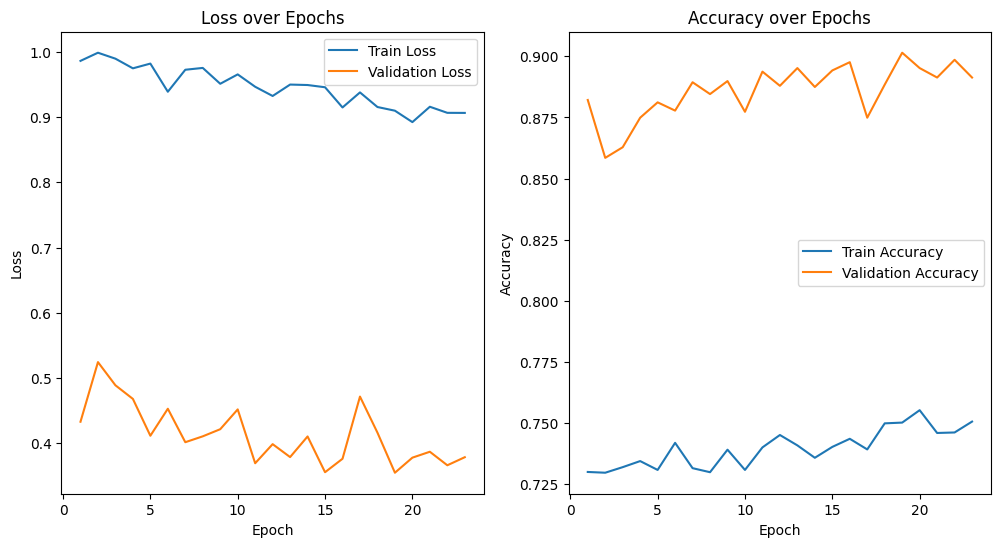

In [ ]:
model.eval()

correct_preds = 0
total_preds = 0


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels.data)
        total_preds += labels.size(0)


test_accuracy = correct_preds.double().cpu().item() / total_preds
print(f"Test Accuracy: {test_accuracy:.4f}")

torch.save(model.state_dict(), "efficientnetb0_leaf_model.pth")

def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()  
    return tensor  
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, to_numpy(torch.tensor(train_losses)), label='Train Loss')
plt.plot(epochs, to_numpy(torch.tensor(val_losses)), label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, to_numpy(torch.tensor(train_accuracies)), label='Train Accuracy')
plt.plot(epochs, to_numpy(torch.tensor(val_accuracies)), label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [ ]:
accuracy = accuracy_score(all_labels, all_preds)

precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:\n", classification_report(all_labels, all_preds))

Accuracy: 0.8787
Precision: 0.8841
Recall: 0.8798
F1-score: 0.8790

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        37
           1       0.81      0.81      0.81        21
           2       0.85      0.89      0.87        38
           3       0.92      1.00      0.96        24
           4       0.86      0.89      0.87        27
           5       0.83      0.77      0.80        26
           6       0.90      0.75      0.82        12
           7       0.92      0.88      0.90        40
           8       0.96      0.86      0.91        28
           9       0.90      0.97      0.93        29
          10       0.88      0.76      0.82        38
          11       0.94      0.88      0.91        17
          12       0.91      0.95      0.93        21
          13       1.00      0.89      0.94        44
          14       0.95      0.95      0.95        39
          15       1.00      0.81      0.90